In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import wavfile
from transformers import Wav2Vec2BertForSequenceClassification, AutoFeatureExtractor
from scipy.signal import resample
import IPython.display as ipd
import os

In [2]:
MODEL_PATH = "pipecat-ai/smart-turn"
TEMP_OUTPUT_WAV = "temp_audio.wav"
RATE = 16000  # Target sample rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print("Loading model...")
model = Wav2Vec2BertForSequenceClassification.from_pretrained(MODEL_PATH).to(device).eval()
processor = AutoFeatureExtractor.from_pretrained(MODEL_PATH)
print("Model loaded successfully!")

Loading model...
Model loaded successfully!


In [4]:
def predict_endpoint(audio_array):
    """Predict whether an audio segment is complete (turn ended) or incomplete."""
    inputs = processor(
        audio_array,
        sampling_rate=16000,
        padding="max_length",
        truncation=True,
        max_length=800,
        return_tensors="pt"
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        completion_prob = probabilities[0, 1].item()
        prediction = int(completion_prob > 0.5)
    
    return {"prediction": prediction, "probability": completion_prob}


In [5]:
def plot_audio_with_predictions(audio, sample_rate, results):
    """Visualize audio waveform with prediction results."""
    plt.figure(figsize=(15, 5))
    
    # Plot waveform
    time = np.arange(len(audio)) / sample_rate
    plt.plot(time, audio, alpha=0.6)
    
    # Add prediction regions
    for result in results:
        color = 'green' if result['prediction'] else 'red'
        plt.axvspan(result['start_time'], result['end_time'], 
                   alpha=0.2, color=color, 
                   label=f"{'Complete' if result['prediction'] else 'Incomplete'}")
    
    # Format plot
    plt.title("Audio Waveform with Turn-Taking Predictions")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicate labels
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()


In [6]:
def process_audio_file(file_path, chunk_duration=3.0, visualize=True, play_audio=False):
    """
    Process an audio file with enhanced debugging and visualization.
    
    Args:
        file_path: Path to audio file
        chunk_duration: Duration of each chunk in seconds
        visualize: Whether to show plots
        play_audio: Whether to play the audio in notebook
    """
    # Load and preprocess audio
    try:
        sample_rate, audio_data = wavfile.read(file_path)
        print(f"Loaded audio: {file_path}")
        print(f"Original sample rate: {sample_rate}Hz, Duration: {len(audio_data)/sample_rate:.2f}s")
    except Exception as e:
        print(f"Error loading audio file: {str(e)}")
        return None

    # Convert to mono and normalize
    if len(audio_data.shape) > 1:
        audio_data = audio_data.mean(axis=1)
        print("Converted stereo to mono")
    
    if np.issubdtype(audio_data.dtype, np.integer):
        audio_data = audio_data.astype(np.float32) / np.iinfo(audio_data.dtype).max
    else:
        audio_data = audio_data.astype(np.float32)
        peak = np.max(np.abs(audio_data))
        if peak > 1.0:
            audio_data = audio_data / peak
    print("Normalized audio to [-1, 1] range")

    # Resample if needed
    if sample_rate != RATE:
        print(f"Resampling from {sample_rate}Hz to {RATE}Hz...")
        target_length = int(len(audio_data) * RATE / sample_rate)
        audio_data = resample(audio_data, target_length)
        sample_rate = RATE
        print(f"New duration: {len(audio_data)/sample_rate:.2f}s")

    # Play audio if requested
    if play_audio:
        print("\nPlaying audio...")
        ipd.display(ipd.Audio(audio_data, rate=sample_rate))

    # Split into chunks (including last partial chunk)
    chunk_size = int(chunk_duration * sample_rate)
    total_samples = len(audio_data)
    total_chunks = (total_samples + chunk_size - 1) // chunk_size
    
    print(f"\nProcessing {total_chunks} chunks (~{chunk_duration}s each):")
    
    # Process each chunk
    results = []
    for i in range(total_chunks):
        start = i * chunk_size
        end = min(start + chunk_size, total_samples)
        chunk = audio_data[start:end]
        chunk_duration = len(chunk)/sample_rate
        
        print(f"\nChunk {i+1}/{total_chunks} ({start/sample_rate:.2f}-{end/sample_rate:.2f}s, {chunk_duration:.2f}s)")
        
        try:
            result = predict_endpoint(chunk)
            results.append({
                'chunk_number': i+1,
                'start_time': start/sample_rate,
                'end_time': end/sample_rate,
                'duration': chunk_duration,
                'prediction': result['prediction'],
                'probability': result['probability']
            })
            print(f"Prediction: {'Complete' if result['prediction'] else 'Incomplete'} (Prob: {result['probability']:.4f})")
        except Exception as e:
            print(f"Error processing chunk: {str(e)}")
            results.append({
                'chunk_number': i+1,
                'start_time': start/sample_rate,
                'end_time': end/sample_rate,
                'duration': chunk_duration,
                'prediction': None,
                'probability': None,
                'error': str(e)
            })

    # Visualization
    if visualize and results:
        plot_audio_with_predictions(audio_data, sample_rate, results)
    
    return results

In [23]:
import os
import sys
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
sys.path.append(data_path)

In [24]:
import warnings     # Suppress WAV file warnings
warnings.filterwarnings("ignore", category=wavfile.WavFileWarning)
audio_file = data_path+r"\audio\enhaced_harvard.wav"  # Change this to your audio file

In [25]:
    
if not os.path.exists(audio_file):
        print(f"Test file not found: {audio_file}")
        print("Please upload an audio file or change the path.")

Loaded audio: d:\PERSONAL\GitHub\College\MOTIVE\backend\data\audio\enhaced_harvard.wav
Original sample rate: 41000Hz, Duration: 19.74s
Converted stereo to mono
Normalized audio to [-1, 1] range
Resampling from 41000Hz to 16000Hz...
New duration: 19.74s

Playing audio...



Processing 7 chunks (~3.0s each):

Chunk 1/7 (0.00-3.00s, 3.00s)
Prediction: Complete (Prob: 0.9973)

Chunk 2/7 (3.00-6.00s, 3.00s)
Prediction: Complete (Prob: 0.9973)

Chunk 3/7 (6.00-9.00s, 3.00s)
Prediction: Complete (Prob: 0.9973)

Chunk 4/7 (9.00-12.00s, 3.00s)
Prediction: Complete (Prob: 0.9973)

Chunk 5/7 (12.00-15.00s, 3.00s)
Prediction: Incomplete (Prob: 0.0025)

Chunk 6/7 (15.00-18.00s, 3.00s)
Prediction: Complete (Prob: 0.9973)

Chunk 7/7 (18.00-19.74s, 1.74s)
Prediction: Complete (Prob: 0.9972)


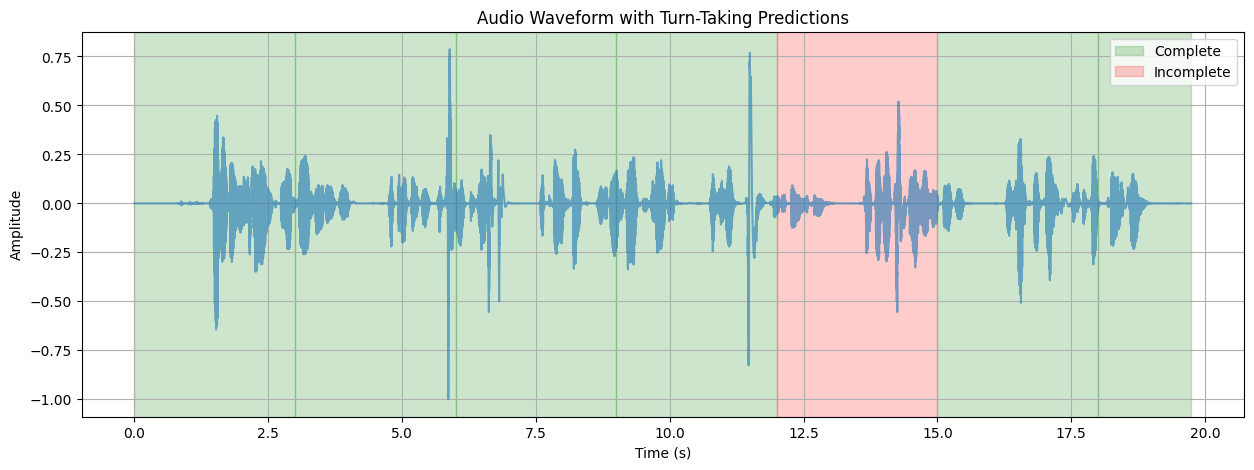


Final Results Summary:
Chunk      Start (s)    End (s)      Prediction Probability 
1          0.00         3.00         Complete   0.9973      
2          3.00         6.00         Complete   0.9973      
3          6.00         9.00         Complete   0.9973      
4          9.00         12.00        Complete   0.9973      
5          12.00        15.00        Incomplete 0.0025      
6          15.00        18.00        Complete   0.9973      
7          18.00        19.74        Complete   0.9972      


In [26]:
results = process_audio_file(audio_file, chunk_duration=3.0, visualize=True, play_audio=True)
        
# Print summary table
print("\nFinal Results Summary:")
print("{:<10} {:<12} {:<12} {:<10} {:<12}".format(
            "Chunk", "Start (s)", "End (s)", "Prediction", "Probability"))
for r in results:
    pred = 'Complete' if r['prediction'] else 'Incomplete' if r['prediction'] is not None else 'Error'
    prob = f"{r['probability']:.4f}" if r['probability'] is not None else "N/A"
    print("{:<10} {:<12.2f} {:<12.2f} {:<10} {:<12}".format(
    r['chunk_number'], r['start_time'], r['end_time'], pred, prob))